In [1]:
import os, dotenv

dotenv.load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["COMPOSIO_API_KEY"] = os.getenv("COMPOSIO_API_KEY")

## GitHub Agent Graph
<img src="../static/Github_Agent.png" alt="Graph" width="600">

In [22]:
from langchain.chat_models import init_chat_model
gemini_model = init_chat_model("gemini-2.0-flash-exp", model_provider="google_genai")

In [32]:
from composio_langgraph import Action, ComposioToolSet

composio_toolset = ComposioToolSet(api_key=os.getenv("COMPOSIO_API_KEY"))

github_tools = composio_toolset.get_tools(
    actions=[
        Action.GITHUB_STAR_A_REPOSITORY_FOR_THE_AUTHENTICATED_USER,
        Action.GITHUB_SEARCH_REPOSITORIES,
        Action.GITHUB_LIST_REPOSITORIES_FOR_THE_AUTHENTICATED_USER,
        Action.GITHUB_LIST_REPOSITORIES_FOR_A_USER,
        Action.GITHUB_GET_THE_AUTHENTICATED_USER,
        Action.GITHUB_LIST_REPOSITORIES_STARRED_BY_A_USER,
        Action.GITHUB_LIST_USER_PROJECTS,
        Action.GITHUB_LIST_FOLLOWERS_OF_A_USER
    ]
)

tools_by_name = {tool.name: tool for tool in github_tools}

In [4]:
tools_by_name

{'GITHUB_LIST_FOLLOWERS_OF_A_USER': StructuredTool(name='GITHUB_LIST_FOLLOWERS_OF_A_USER', description='Lists The People Following The Specified User.', args_schema=<class 'composio.utils.shared.ListFollowersOfAUserRequest'>, func=<function ComposioToolSet._wrap_action.<locals>.function at 0x000001E38D3896C0>),
 'GITHUB_LIST_REPOSITORIES_FOR_A_USER': StructuredTool(name='GITHUB_LIST_REPOSITORIES_FOR_A_USER', description='Lists Public Repositories For The Specified User.', args_schema=<class 'composio.utils.shared.ListRepositoriesForAUserRequest'>, func=<function ComposioToolSet._wrap_action.<locals>.function at 0x000001E38D389300>),
 'GITHUB_LIST_REPOSITORIES_STARRED_BY_A_USER': StructuredTool(name='GITHUB_LIST_REPOSITORIES_STARRED_BY_A_USER', description="This Endpoint Lists Repositories A User Has Starred And Supports Media Types Like `Application/Vnd.Github.Star+Json`, Which Includes The Star's Creation Timestamp. For More, Visit Git Hub's Documentation On Media Types.", args_schema

In [5]:
from langgraph.graph import MessagesState

class GitHubGraphState(MessagesState):
    pass


In [23]:
agent_with_tools = gemini_model.bind_tools(github_tools) 

In [7]:
GITHUB_AGENT_PROMPT = """
You are a sophisticated GitHub assistant designed to help users interact with and manage their GitHub repositories and activities.

---
## Instructions
1. **Analyze user request carefully.** Identify the core task(s) and required information. If the request is unclear, ask for clarification.
2. **Select the most appropriate tool(s)** for the task(s). Use minimal tools for simple requests while intelligently combining tools for complex operations.
3. **If uncertain about tool selection, review tool descriptions and task requirements.**
4. **Execute chosen tool(s) with proper parameters** to complete the task.
5. **Execute tools in a logical sequence** when multiple operations are needed.
6. **Provide clear results** back to the user.

## Core capabilities
- Search and explore repositories
- Star repositories
- View and manage personal repositories
- Access user profile information
- View starred repositories
- Browse user projects
- Manage follower relationships
- List repositories for specific users

## Best Practices
- When searching repositories, provide concise but relevant results
- For repository listings, limit results to most relevant entries
- Present information in an organized manner
- Include essential details to the user

## Privacy & Security
Do NOT disclose internal tool operations or implementation details

## NOTE
Some tools may depend on other tools. Make sure to handle tools efficiently.
When fetching repository lists or search results, limit to maximum of 5-10 items unless specifically requested otherwise.
---
User Name: {user_name}
User Handle: {github_username}
System time: {system_time}

"""

In [8]:
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, ToolMessage
from datetime import datetime

agent_with_tools.invoke(
    [SystemMessage(content=GITHUB_AGENT_PROMPT.format(user_name="Aasher Kamal", 
    github_username="aasherkamal216", 
    system_time=datetime.now().isoformat()))]
     + [HumanMessage(content="Get my Followers")]
    )

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_m86t', 'function': {'arguments': '{"username": "aasherkamal216"}', 'name': 'GITHUB_LIST_FOLLOWERS_OF_A_USER'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 2950, 'total_tokens': 2975, 'completion_time': 0.090909091, 'prompt_time': 0.34694781, 'queue_time': 2.248759544, 'total_time': 0.437856901}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4e32347616', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e525af85-aaf2-4d7e-a173-2819934c4c22-0', tool_calls=[{'name': 'GITHUB_LIST_FOLLOWERS_OF_A_USER', 'args': {'username': 'aasherkamal216'}, 'id': 'call_m86t', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2950, 'output_tokens': 25, 'total_tokens': 2975})

In [24]:
from typing import Literal
from langgraph.types import Command, interrupt

def github_agent(
    state: GitHubGraphState,
) -> Command[Literal["action_executor", "__end__"]]:

    response = agent_with_tools.invoke(
        [
            SystemMessage(
                content=GITHUB_AGENT_PROMPT.format(
                    user_name="Aasher Kamal",
                    github_username="aasherkamal216",
                    system_time=datetime.now().isoformat(),
                )
            )
        ]
        + state["messages"]
    )
    if hasattr(response, "tool_calls") and response.tool_calls:
        # Route to Action Executor
        return Command(goto="action_executor", update={"messages": [response]})
    # End of Conversation
    return Command(update={"messages": [response]}, goto="__end__")

In [25]:
def action_node(state: GitHubGraphState) -> Command[Literal["github_agent"]]:
    tool_calls = state["messages"][-1].tool_calls
    result = []
    for call in tool_calls:
        tool_name = call["name"]
        args = call.get("args")
        # Confirm action by user
        decision = interrupt(
            {
                "tool_name": tool_name.replace("_", " ").title(),
                "confirmation": "Do you confirm the action? [y/n]: ",
            }
        )

        if decision.lower().strip() == "y":
            output = tools_by_name[tool_name].invoke(args)
        elif decision.lower().strip() == "n":
            output = "User declined to perform this action."
        result.append(
            ToolMessage(content=output, tool_call_id=call["id"], name=tool_name)
        )
    return Command(goto="github_agent", update={"messages": result})

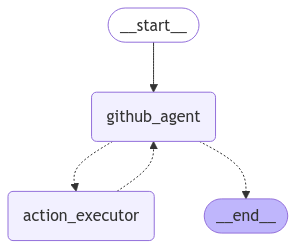

In [34]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from typing import TypedDict, Annotated
from IPython.display import Image, display

# Build graph
builder = StateGraph(GitHubGraphState)

builder.add_node("github_agent", github_agent)
builder.add_node("action_executor", action_node)


builder.add_edge(START, "github_agent")

## Checkpointer
checkpointer = MemorySaver()
github_graph = builder.compile(checkpointer=checkpointer)

display(Image(github_graph.get_graph(xray=1).draw_mermaid_png()))

In [14]:
config = {"configurable": {"thread_id": "1"}}

for chunk in github_graph.stream(
    {"messages": [HumanMessage(content="Get my followers")]},
    config=config,
    stream_mode="values"
):
    response_message = chunk["messages"][-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()


================================ Human Message =================================

Get my followers
================================== Ai Message ==================================
Tool Calls:
  GITHUB_LIST_FOLLOWERS_OF_A_USER (call_nzaf)
 Call ID: call_nzaf
  Args:
    username: aasherkamal216


In [ ]:
for chunk in github_graph.stream(
    Command(resume="y"),
    config=config,
    stream_mode="values"
):
    response_message = chunk.get("messages")[-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()
    else:
        print(chunk)

In [ ]:
for chunk in github_graph.stream(
    {"messages": [HumanMessage(content="Give me their github links")]},
    config=config,
    stream_mode="values"
):
    response_message = chunk["messages"][-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()


In [35]:
config = {"configurable": {"thread_id": "2"}}
for chunk in github_graph.stream(
    {"messages": [HumanMessage(content="Which repos have I starred?")]},
    config=config,
    stream_mode="values"
):
    response_message = chunk["messages"][-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()


================================ Human Message =================================

Which repos have I starred?
================================== Ai Message ==================================
Tool Calls:
  GITHUB_LIST_REPOSITORIES_STARRED_BY_A_USER (bd0ced12-a8d7-493c-acc4-04b0e93afa4a)
 Call ID: bd0ced12-a8d7-493c-acc4-04b0e93afa4a
  Args:
    username: aasherkamal216


In [ ]:
for chunk in github_graph.stream(
    Command(resume="y"),
    config=config,
    stream_mode="values"
):
    response_message = chunk.get("messages")[-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()
    else:
        print(chunk)